In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

seed=456

In [7]:
y_train

9748    0
5736    0
2143    0
9987    1
4156    0
       ..
1445    0
7228    1
9116    0
6186    1
613     1
Name: player_won, Length: 8000, dtype: int64

In [40]:
##  Extracting data
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

model_path = config["model"]["path"]
output_path = config["output"]["path"]

train_df = pd.read_csv(config["data"]["processed_train_path"])
test_df = pd.read_csv(config["data"]["processed_test_path"])

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']
#print(features)

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train,train_size=0.8,shuffle=True, random_state=seed)
print(len (X_test.columns),len(X_train.columns))


110 110


In [41]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_vali=scaler.transform(X_vali)
X_test = scaler.transform(X_test)

## Logistic Regression

In [4]:
## GRID SEARCH
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data


model = LogisticRegression(random_state=seed)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
         ## comment if u change the dataset
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_logreg = grid_search.best_estimator_
best_param_lr = grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8270
 Standard deviation across validation folds: 0.0063
Best hyperparameters found: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy in CV: 0.8270


In [5]:
## TRAINING IN THE TRAINING SET
logreg=LogisticRegression(**best_param_lr,random_state=seed)
logreg.fit(X_train,y_train)
y_pred= logreg.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))
best_logreg=logreg

acc 0.832


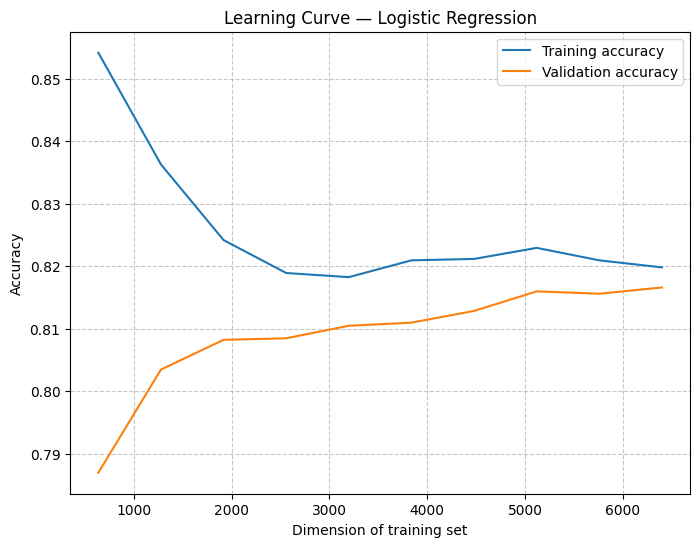

In [173]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    logreg, X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=seed,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.plot(train_sizes, val_mean, label='Validation accuracy')
plt.xlabel('Dimension of training set')
plt.ylabel('Accuracy')
plt.title('Learning Curve — Logistic Regression')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## KNN

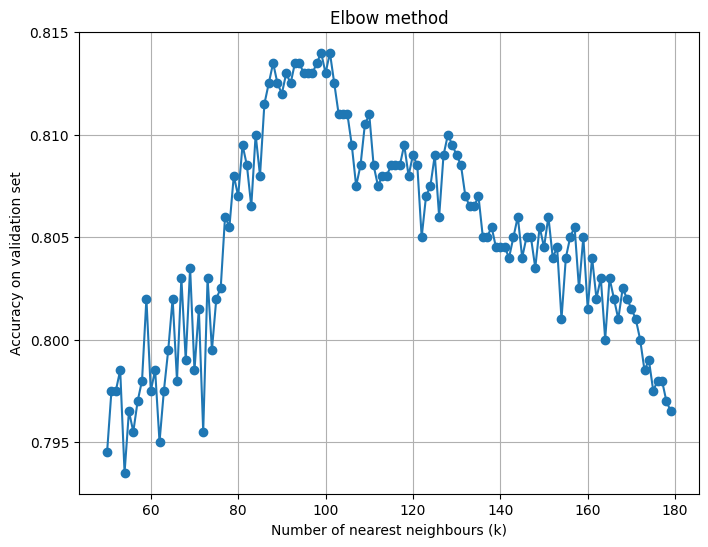

Best k: 99
Accuracy for validation set: 0.8140
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.7883
 Standard deviation across validation folds: 0.0047
Best hyperparameters found: {'metric': 'minkowski', 'n_neighbors': 99, 'weights': 'uniform'}
Best accuracy in CV: 0.7883


In [174]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



model = KNeighborsClassifier()

k_values = list(range(50,180))
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_vali)
    acc = accuracy_score(y_vali, y_pred)
    accuracies.append(acc)


plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

param_grid = {
    'n_neighbors': [best_k],           
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','manhattan', 'euclidean'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)


grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_knn = grid_search.best_estimator_
best_param_knn = grid_search.best_params_

In [175]:
### This is the total knn classifier

best_knn = KNeighborsClassifier(**best_param_knn)
best_knn.fit(X_train, y_train)
y_pred= best_knn.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))

acc 0.814


# DECISION TREES


In [176]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score


# No need to scale the data

model = DecisionTreeClassifier(random_state=seed)

k_range = list(range(60,200,20))

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], # impurity function to minimize
    'max_depth': [15], # max_depth of the tree
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_dt = grid_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
 Best model mean validation accuracy: 0.7315
 Standard deviation across validation folds: 0.0069
Best hyperparameters found: {'criterion': 'gini', 'max_depth': 15}
Best accuracy in CV: 0.7315


# RANDOM FOREST

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Random Forest
rforest = RandomForestClassifier(
    criterion='gini',
    max_depth=10,
    n_estimators=400,
    random_state=seed
)

# K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Calcolo dell’accuracy media con cross-validation
scores = cross_val_score(rforest, X_train, y_train, cv=kfold, scoring='accuracy')

print("Accuracy per fold:", np.round(scores, 3))
print(f"Accuracy in mean +- stddev: {scores.mean():.3f} ± {scores.std():.3f}")


Accuracy per fold: [0.806 0.808 0.808 0.809 0.814]
Accuracy in mean +- stddev: 0.809 ± 0.003


In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [30, 40],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

# Initialize the base model
rforest = RandomForestClassifier(random_state=seed)

# Set up K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up the Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rforest,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,       # use all available CPU cores
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_rf = grid_search.best_params_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8105
 Standard deviation across validation folds: 0.0037
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best accuracy in CV: 0.8126


In [179]:
best_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
best_rf.fit(X_train, y_train)
y_pred= best_rf.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))

acc 0.823


# XGBOOST


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np
import xgboost as xgb

# Base XGBoost model
xgb = XGBClassifier(
    random_state=seed,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [500, 600],
    'max_depth': [4,5],
    'learning_rate': [0.04, 0.03],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
# Retrieve the best model
best_xgb = grid_search.best_estimator_

best_param_xgb = grid_search.best_params_


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\franc\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:30:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best model mean validation accuracy: 0.8295
 Standard deviation across validation folds: 0.0050
Best hyperparameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.8}
Best accuracy in CV: 0.8295


[0]	validation_0-logloss:0.68131	validation_1-logloss:0.68148
[1]	validation_0-logloss:0.67009	validation_1-logloss:0.67023
[2]	validation_0-logloss:0.65950	validation_1-logloss:0.65985
[3]	validation_0-logloss:0.64951	validation_1-logloss:0.64993
[4]	validation_0-logloss:0.64018	validation_1-logloss:0.64058
[5]	validation_0-logloss:0.63162	validation_1-logloss:0.63216
[6]	validation_0-logloss:0.62297	validation_1-logloss:0.62353
[7]	validation_0-logloss:0.61477	validation_1-logloss:0.61528
[8]	validation_0-logloss:0.60697	validation_1-logloss:0.60764
[9]	validation_0-logloss:0.59956	validation_1-logloss:0.60028
[10]	validation_0-logloss:0.59286	validation_1-logloss:0.59339
[11]	validation_0-logloss:0.58603	validation_1-logloss:0.58649
[12]	validation_0-logloss:0.57951	validation_1-logloss:0.57998
[13]	validation_0-logloss:0.57338	validation_1-logloss:0.57391
[14]	validation_0-logloss:0.56750	validation_1-logloss:0.56808
[15]	validation_0-logloss:0.56192	validation_1-logloss:0.56240
[1

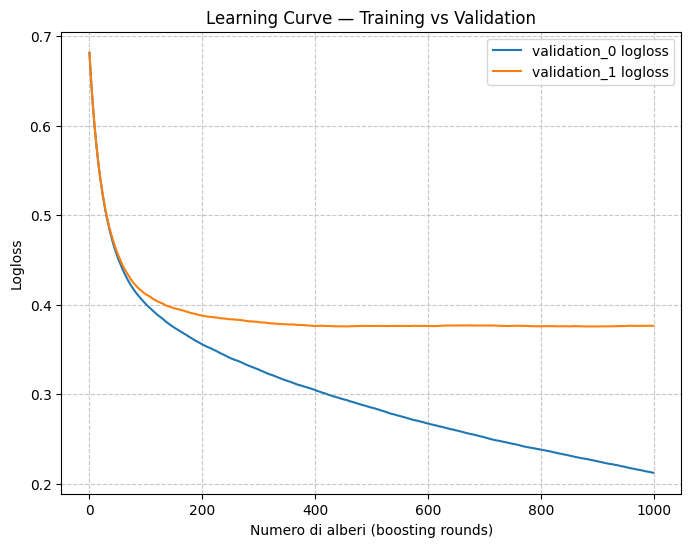

In [61]:
evals_result = {}
best_xgb = XGBClassifier(**best_param_xgb, random_state=seed)
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_vali, y_vali)])
y_pred= best_xgb.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))

evals_result = best_xgb.evals_result()
print("Chiavi disponibili in evals_result:", evals_result.keys())

# 3️⃣ Recupera le curve in modo dinamico
keys = list(evals_result.keys())
train_key, vali_key = keys[0], keys[1]

train_loss = evals_result[train_key]['logloss']
vali_loss = evals_result[vali_key]['logloss']

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(train_loss, label=f'{train_key} logloss')
plt.plot(vali_loss, label=f'{vali_key} logloss')
plt.xlabel('Numero di alberi (boosting rounds)')
plt.ylabel('Logloss')
plt.title('Learning Curve — Training vs Validation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Playing with feature importance

🔝 Top 10 most important features:
   Feature  Importance
97    f109   95.815765
60     f63   27.297710
53     f56   27.260489
52     f55   20.997410
58     f61   14.917353
67     f71   14.336660
57     f60   14.094752
68     f72   13.269799
59     f62   12.976303
56     f59   11.489942

🔻 Least important 10 features:
   Feature  Importance
32     f32    4.667206
43     f46    4.649854
79     f91    4.638133
34     f34    4.612921
83     f95    4.597104
35     f35    4.430594
64     f68    4.382221
10     f10    3.974015
37     f38    3.867775
40     f42    3.080040


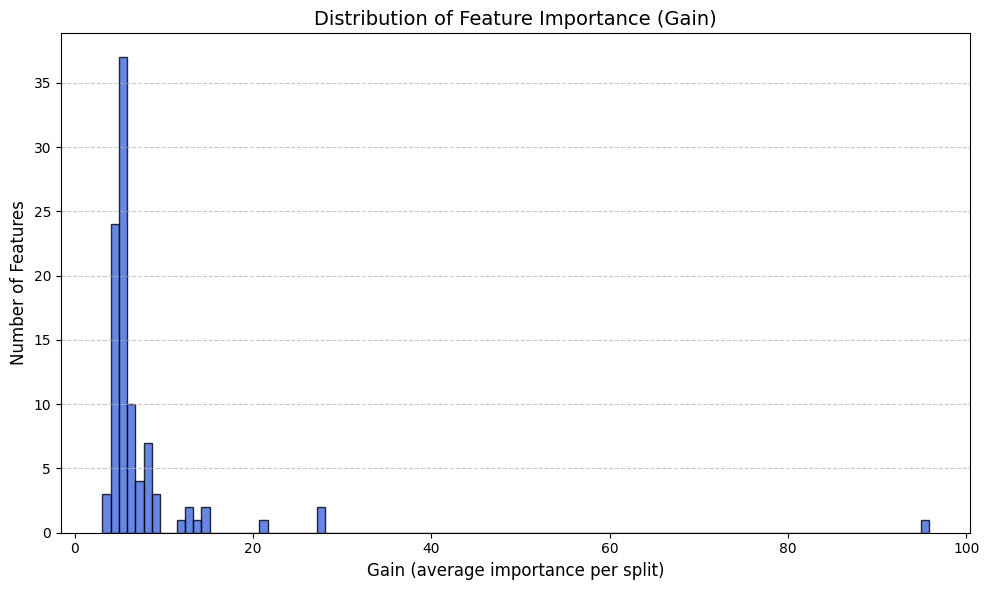

In [13]:
# Extract the trained booster from the best XGBoost model
booster = best_xgb.get_booster()

# Compute feature importance using 'gain' (average contribution to model decisions)
importance = booster.get_score(importance_type='gain')

# Convert to DataFrame and sort by importance
importance_df = (
    pd.DataFrame({'Feature': list(importance.keys()), 'Importance': list(importance.values())})
    .sort_values(by='Importance', ascending=False)
)

# Display the top and bottom 10 most important features
print("🔝 Top 10 most important features:")
print(importance_df.head(10))

print("\n🔻 Least important 10 features:")
print(importance_df.tail(10))

# Plot the distribution of feature importance values
plt.figure(figsize=(10, 6))
plt.hist(importance_df['Importance'], bins=100, color='royalblue', edgecolor='black', alpha=0.8)
plt.title('Distribution of Feature Importance (Gain)', fontsize=14)
plt.xlabel('Gain (average importance per split)', fontsize=12)
plt.ylabel('Number of Features', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Get the ordered list of feature names by importance
feature_names = importance_df['Feature'].tolist()


In [17]:
# Create placeholder column names
X_train = pd.DataFrame(X_train, columns=[f"f{i}" for i in range(X_train.shape[1])])
X_vali = pd.DataFrame(X_vali, columns=[f"f{i}" for i in range(X_vali.shape[1])])
X_test = pd.DataFrame(X_test, columns=[f"f{i}" for i in range(X_test.shape[1])])
# Check consistency of dimensions
if X_vali.shape[0] != len(y_vali):
    raise ValueError(f"⚠️ Dimension mismatch: X_vali={X_vali.shape[0]}, y_vali={len(y_vali)}")

# Compute the 20th percentile of feature gain and identify the weakest features
p = importance_df['Importance'].quantile(0.05)
worst_feats = importance_df[importance_df['Importance'] < p]['Feature'].tolist()

print(f"Removing {len(worst_feats)} features with gain below the 20th percentile ({p:.4f})")

# Drop the weakest features from both train and validation sets
X_train_reduced = X_train.drop(columns=worst_feats, errors='ignore')
X_vali_reduced = X_vali.drop(columns=worst_feats, errors='ignore')
X_test_reduced = X_test.drop(columns=worst_feats, errors='ignore')
print(f"Original shape: {X_train.shape}")
print(f"Reduced shape:  {X_train_reduced.shape}")

# Retrain a new model using the reduced feature set
xgb_new = XGBClassifier(**best_param_xgb, random_state=seed)
xgb_new.fit(X_train_reduced, y_train)

# Compare accuracy before and after feature selection
acc_before = best_xgb.score(X_vali, y_vali)
acc_after = xgb_new.score(X_vali_reduced, y_vali)


print(f"\n🎯 Original accuracy: {acc_before:.4f}")
print(f"🧹 Accuracy after feature selection (20th percentile): {acc_after:.4f}")

# (Optional) Display the 10 least important features removed
print("\n🔻 10 features with the lowest gain:")
print(importance_df.sort_values(by='Importance', ascending=True).head(10))


Removing 5 features with gain below the 20th percentile (4.5721)
Original shape: (7999, 110)
Reduced shape:  (7999, 105)

🎯 Original accuracy: 0.8465
🧹 Accuracy after feature selection (20th percentile): 0.8450

🔻 10 features with the lowest gain:
   Feature  Importance
40     f42    3.080040
37     f38    3.867775
10     f10    3.974015
64     f68    4.382221
35     f35    4.430594
83     f95    4.597104
34     f34    4.612921
79     f91    4.638133
43     f46    4.649854
32     f32    4.667206


In [18]:
####### let's try if it works for rf and logreg
best_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
best_rf.fit(X_train, y_train)
new_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
new_rf.fit(X_train_reduced, y_train)
y_pred= best_rf.predict(X_vali)
print("Random Forest")
print("first acc",accuracy_score(y_vali,y_pred))
y_pred2 = new_rf.predict(X_vali_reduced)
print("second acc",accuracy_score(y_vali,y_pred2))

new_lr = LogisticRegression(**best_param_lr,random_state=seed)
new_lr.fit(X_train_reduced, y_train)
y_pred= best_logreg.predict(X_vali)
print("Logistic regression")
print("first acc",accuracy_score(y_vali,y_pred))
y_pred2 = new_lr.predict(X_vali_reduced)
print("second acc",accuracy_score(y_vali,y_pred2))

NameError: name 'RandomForestClassifier' is not defined

In [53]:
seeds = [123, 456, 789]
xgb_models = []

for s in seeds:
    model = XGBClassifier(**best_param_xgb, random_state=s)
    xgb.fit(X_train, y_train)
    xgb_models.append(model)

print(f"✅ Allenati {len(xgb_models)} modelli XGBoost con seed diversi.")
estimators = [
    ('1', xgb_models[0]),
    ('2', xgb_models[1]),
    ('logreg', best_logreg),
    ('3', xgb_models[2])
]

# Meta-learner (impara a combinare i modelli)
meta_model = LogisticRegression(random_state=seed, max_iter=10000)

# Stacking ensemble
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True  # include anche le feature originali
)

stack.fit(X_train, y_train)
print("Stacking accuracy:", stack.score(X_vali, y_vali))
best_stck=stack

c:\Users\franc\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:25:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Allenati 3 modelli XGBoost con seed diversi.
Stacking accuracy: 0.847


# ENSEMBLE

In [54]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('logreg', best_logreg),
        ('knn', best_knn)
    ],
    voting='soft'  # or 'hard' if models don’t support predict_proba
)

ensemble.fit(X_train, y_train)

print("Ensemble accuracy:", ensemble.score(X_vali, y_vali))

NameError: name 'best_rf' is not defined

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('logreg', best_logreg),
    ('knn', best_knn)
]

# Meta-learner (impara a combinare i modelli)
meta_model = LogisticRegression(random_state=seed, max_iter=10000)

# Stacking ensemble
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True  # include anche le feature originali
)

stack.fit(X_train, y_train)
print("Stacking accuracy:", stack.score(X_vali, y_vali))

NameError: name 'best_rf' is not defined

In [25]:
print(X_test)

            f0        f1        f2        f3        f4        f5        f6  \
0     1.200123  1.598199  0.407302 -0.140947 -0.574398 -0.569461 -0.767226   
1     0.451173 -0.471413  0.407302  0.092864 -0.574398  0.023071  0.469546   
2    -2.482217 -0.471413 -3.249667  1.729540  1.463214  1.546726  0.116183   
3     0.825648  0.563393  0.407302  1.145013  1.463214  0.530956  0.116183   
4    -1.546029  0.563393 -1.862541  2.080256  1.463214  1.038841  0.116183   
...        ...       ...       ...       ...       ...       ...       ...   
4995 -2.107741 -1.506219 -1.862541  2.080256 -0.574398  2.985734  2.236364   
4996  0.263935 -0.471413  0.407302 -1.310001 -0.574398 -1.585231 -0.767226   
4997 -0.784596 -0.471413  0.407302  0.069483  1.870737  0.107719  0.469546   
4998  0.638410  0.563393  0.407302  0.209769 -0.574398 -0.061576 -0.767226   
4999 -0.921903 -1.506219  0.407302 -0.257853  1.463214  1.631374  2.236364   

            f7        f8        f9  ...      f100      f101    

In [49]:
best_model=best_stck
#best_model=best_xgb

# SUBMISSIONS


In [50]:
# Testing the prediction on the test set

print("Generating predictions on the test set...")
test_predictions = best_model.predict(X_test)

Generating predictions on the test set...


In [51]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})
# Save the DataFrame to a .csv file
submission_df.to_csv(output_path, index=False)

print("\n'submission.csv' file created successfully!")


'submission.csv' file created successfully!
